# Analysis of Crime occurence in Vancouver City from 2013 to 2022
#### University of British Columbia
#### ECON 323-004 2022W2 Final Project 

Collabrators and Contributions:
- Yiming Li(Student number: 52680360): I am accountable for ideating the overarching
concept of the project, formulating the research objectives, and leveraging python code
to construct and evaluate the time series model.
- Pengchao Chen(Student number: 31253933): I contributed to the project by coding and
writing content, as well as building and selecting models.
- Sawyer Wang(Student number: 63591192): Providing the draft of proposal, searching
the datafile and taking the responsibility of cleaning data and representing data.
- Zhihao Wu(Student number: 56834187): Writing the introduction and conclusion, helping
modify the code and annotate the coding.


### 1. Introduction:

### 2. Literature Review:

### 3. Data Pre-Processing

#### A) Load Dataset

In [1]:
# Load package
! pip install pyproj
import pandas as pd
import numpy as np
from pyproj import Proj
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter1d

## model building package
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
! pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

In [2]:
# Load dataset
df_original = pd.read_csv('crimedata_csv_AllNeighbourhoods_AllYears.csv')
df_original.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Theft from Vehicle,2018,3,22,9,0,19XX TRIUMPH ST,Grandview-Woodland,495328.9875,5.459026e+06
1,Theft from Vehicle,2004,4,6,7,0,19XX TRIUMPH ST,Grandview-Woodland,495341.1965,5.459026e+06
2,Theft from Vehicle,2003,2,24,0,0,19XX TRIUMPH ST,Grandview-Woodland,495354.4033,5.459026e+06
3,Theft from Vehicle,2019,8,19,16,0,19XX TRIUMPH ST,Grandview-Woodland,495354.4033,5.459026e+06
4,Theft from Vehicle,2018,11,8,1,0,19XX TRIUMPH ST,Grandview-Woodland,495356.5750,5.459026e+06


In [3]:
# Print out the column names, their data types, and count of non-NA values
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854615 entries, 0 to 854614
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           854615 non-null  object 
 1   YEAR           854615 non-null  int64  
 2   MONTH          854615 non-null  int64  
 3   DAY            854615 non-null  int64  
 4   HOUR           854615 non-null  int64  
 5   MINUTE         854615 non-null  int64  
 6   HUNDRED_BLOCK  854603 non-null  object 
 7   NEIGHBOURHOOD  854475 non-null  object 
 8   X              854542 non-null  float64
 9   Y              854542 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 65.2+ MB


In [4]:
# Check if the dataset contains any missing value
df_original.isnull().values.any()

True

In [5]:
# Count the number of missing values for each column
df_original.isnull().sum()

TYPE               0
YEAR               0
MONTH              0
DAY                0
HOUR               0
MINUTE             0
HUNDRED_BLOCK     12
NEIGHBOURHOOD    140
X                 73
Y                 73
dtype: int64

#### B) Data Wrangling

In [6]:
# Drop the rows of missing values and check again if the dataset still contains missing value
df_new = df_original.dropna()
df_new.isnull().values.any()

False

In [7]:
# Drop Day, Hour, Minute columns
df = df_new.drop(columns=['DAY','HOUR','MINUTE'])                       

In [8]:
# Convet UTM zone 10 coordinates in columns "X" and "Y" to latitute and longitude
myProj = Proj(proj='utm',zone=10,ellps='WGS84', preserve_units=False)
LONGITUDE, LATITUDE= myProj(df['X'].values, df['Y'].values, inverse=True)
df["LATITUDE"] = LATITUDE
df["LONGITUDE"] = LONGITUDE

# Drop "X" and "Y" Columns
df = df.drop(columns=['X', 'Y'])

# Create a new column "Coordinates" to zip the latitude and longtitude together
df["COORDINATES"] = list(zip(df.LATITUDE, df.LONGITUDE))
df.head()

,TYPE,YEAR,MONTH,HUNDRED_BLOCK,NEIGHBOURHOOD,LATITUDE,LONGITUDE,COORDINATES
0,Theft from Vehicle,2018,3,19XX TRIUMPH ST,Grandview-Woodland,49.283967,-123.064228,"(49.283967044254, -123.06422771478474)"
1,Theft from Vehicle,2004,4,19XX TRIUMPH ST,Grandview-Woodland,49.283967,-123.064060,"(49.28396661302445, -123.06405983708636)"
2,Theft from Vehicle,2003,2,19XX TRIUMPH ST,Grandview-Woodland,49.283966,-123.063878,"(49.28396614416044, -123.06387823931564)"
3,Theft from Vehicle,2019,8,19XX TRIUMPH ST,Grandview-Woodland,49.283966,-123.063878,"(49.28396614416044, -123.06387823931564)"
4,Theft from Vehicle,2018,11,19XX TRIUMPH ST,Grandview-Woodland,49.283966,-123.063848,"(49.2839660644158, -123.0638483777353)"


In [9]:
# Create a list of tuples containing the neighborhood and its corresponding area(East, West, Central)
neighborhoods = [
    ('Arbutus Ridge', 'West'),
    ('Dunbar-Southlands', 'West'),
    ('Kerrisdale', 'West'),
    ('Kitsilano', 'West'),
    ('Marpole', 'West'),
    ('West Point Grey', 'West'),
    ('Central Business District', 'Central'),
    ('Fairview', 'Central'),
    ('Oakridge', 'Central'),
    ('Shaughnessy', 'Central'),
    ('South Cambie', 'Central'),
    ('Stanley Park', 'Central'),
    ('West End', 'Central'),
    ('Grandview-Woodland', 'East'),
    ('Hastings-Sunrise', 'East'),
    ('Kensington-Cedar Cottage', 'East'),
    ('Killarney', 'East'),
    ('Mount Pleasant', 'East'),
    ('Musqueam', 'East'),
    ('Renfrew-Collingwood', 'East'),
    ('Riley Park', 'East'),
    ('Strathcona', 'East'),
    ('Sunset', 'East'),
    ('Victoria-Fraserview', 'East')
]

In [10]:
# Create a dictionary to store the neighborhoods by area
neighborhoods_by_area = {}

# Loop through the list of tuples and add neighborhoods to the new dictionary
for neighborhood, area in neighborhoods:
    neighborhoods_by_area[neighborhood] = area

# Replace neighborhood names with area names
df['AREA'] = df['NEIGHBOURHOOD'].map(neighborhoods_by_area)

# Select 11 Year from the whole data frame
df_12 = df[df["YEAR"] > 2011]
df_12_22 = df_12[df_12["YEAR"] < 2023]

# Show the clean data
df_12_22.head()

,TYPE,YEAR,MONTH,HUNDRED_BLOCK,NEIGHBOURHOOD,LATITUDE,LONGITUDE,COORDINATES,AREA
0,Theft from Vehicle,2018,3,19XX TRIUMPH ST,Grandview-Woodland,49.283967,-123.064228,"(49.283967044254, -123.06422771478474)",East
3,Theft from Vehicle,2019,8,19XX TRIUMPH ST,Grandview-Woodland,49.283966,-123.063878,"(49.28396614416044, -123.06387823931564)",East
4,Theft from Vehicle,2018,11,19XX TRIUMPH ST,Grandview-Woodland,49.283966,-123.063848,"(49.2839660644158, -123.0638483777353)",East
9,Theft from Vehicle,2015,10,19XX TRIUMPH ST,Grandview-Woodland,49.283884,-123.063842,"(49.2838837987591, -123.06384241666127)",East
10,Theft from Vehicle,2017,12,19XX TRUTCH ST,Kitsilano,49.268493,-123.175687,"(49.26849341937595, -123.17568704098085)",West


In [11]:
# Sum different crime cases in each month
df_new = df_12_22.groupby(['TYPE', 'YEAR', 'MONTH', 'AREA']).size().reset_index(name='COUNT')

df_new.head(20)

,TYPE,YEAR,MONTH,AREA,COUNT
0,Break and Enter Commercial,2012,1,Central,96
1,Break and Enter Commercial,2012,1,East,52
2,Break and Enter Commercial,2012,1,West,8
3,Break and Enter Commercial,2012,2,Central,61
4,Break and Enter Commercial,2012,2,East,38
5,Break and Enter Commercial,2012,2,West,19
6,Break and Enter Commercial,2012,3,Central,77
7,Break and Enter Commercial,2012,3,East,73
8,Break and Enter Commercial,2012,3,West,15
9,Break and Enter Commercial,2012,4,Central,71


## Visualize the number of crimes in three areas

In [12]:
# Combine the year and month, and make it to a new column
df_new = df_new.reset_index(drop = True)
df_new['DATE'] = df_new['YEAR'].astype(str) + '-' + df_new['MONTH'].astype(str)

# Set date to index
df_new = df_new.set_index('DATE')

# Central
df_central = df_new[df_new['AREA'] == "Central"]
# East
df_east = df_new[df_new["AREA"] == "East"]
# West
df_west = df_new[df_new["AREA"] == "West"]

### West

In [13]:
# Remove unuseful columns: "YEAR", "MONTH" and "AREA"
df_west = df_west.drop(columns = ['YEAR', 'MONTH', 'AREA'])   
df_west.head()

,TYPE,COUNT
DATE,,
2012-1,Break and Enter Commercial,8
2012-2,Break and Enter Commercial,19
2012-3,Break and Enter Commercial,15
2012-4,Break and Enter Commercial,14
2012-5,Break and Enter Commercial,7


Plot each crime types in west area from 2012 to 2022

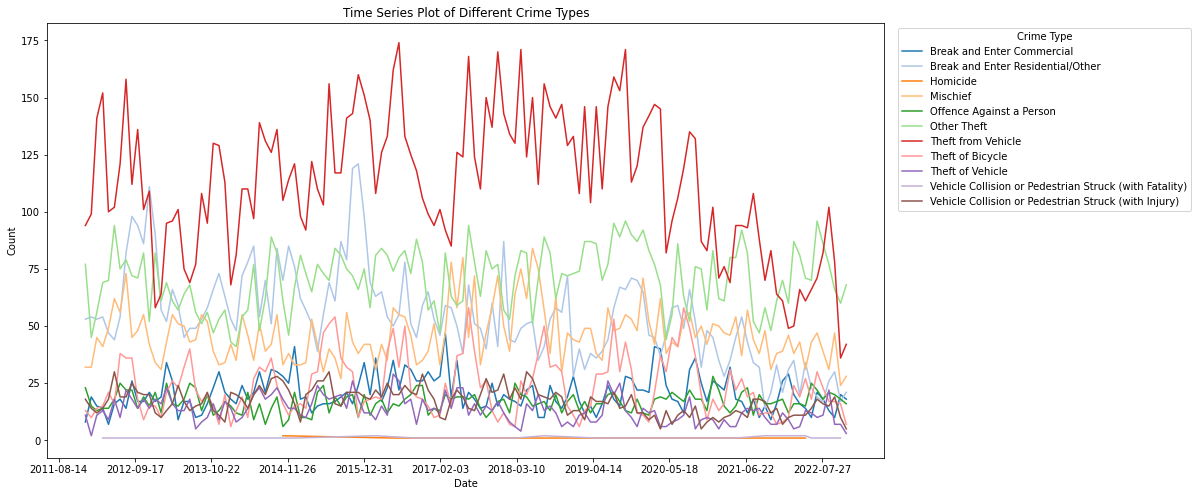

In [14]:
# Reset the index and create a proper 'DATE' column
df_west1 = df_west.reset_index()

# Convert the 'DATE' column to datetime format
df_west1['DATE'] = pd.to_datetime(df_west1['DATE'], format="%Y-%m")

# Create a custom color palette
num_colors = 11  # Adjust this number based on the number of crime types
color_palette = cm.tab20.colors[:num_colors]

# Create a time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_west1, x='DATE', y='COUNT', hue='TYPE', palette=color_palette)

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type')

plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

Plot smoothed time series plot of West area

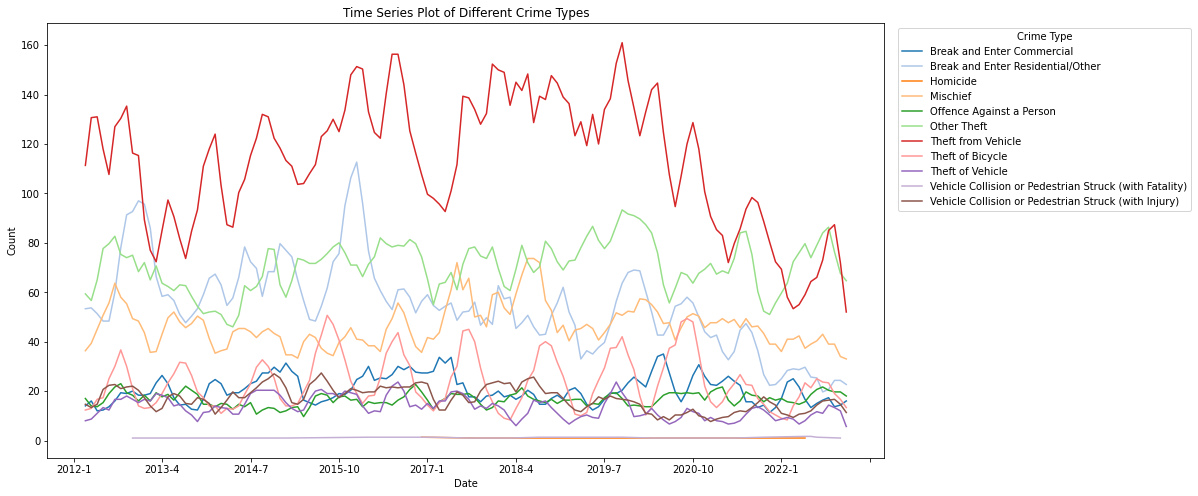

In [15]:
# Using moving average where lag = 3
df_west_smoothed = df_west.groupby(['TYPE']).rolling(window=3).mean()
df_west_smoothed.reset_index(inplace=True)

# Create a smoothed time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_west_smoothed, x='DATE', y='COUNT', hue='TYPE', palette=color_palette, estimator='mean')

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

## East

In [16]:
# Remove unuseful columns: "YEAR", "MONTH" and "AREA"
df_east = df_east.drop(columns = ['YEAR', 'MONTH', 'AREA'])   
df_east.head()

,TYPE,COUNT
DATE,,
2012-1,Break and Enter Commercial,52
2012-2,Break and Enter Commercial,38
2012-3,Break and Enter Commercial,73
2012-4,Break and Enter Commercial,70
2012-5,Break and Enter Commercial,60


Plot each crime types in east area from 2012 to 2022

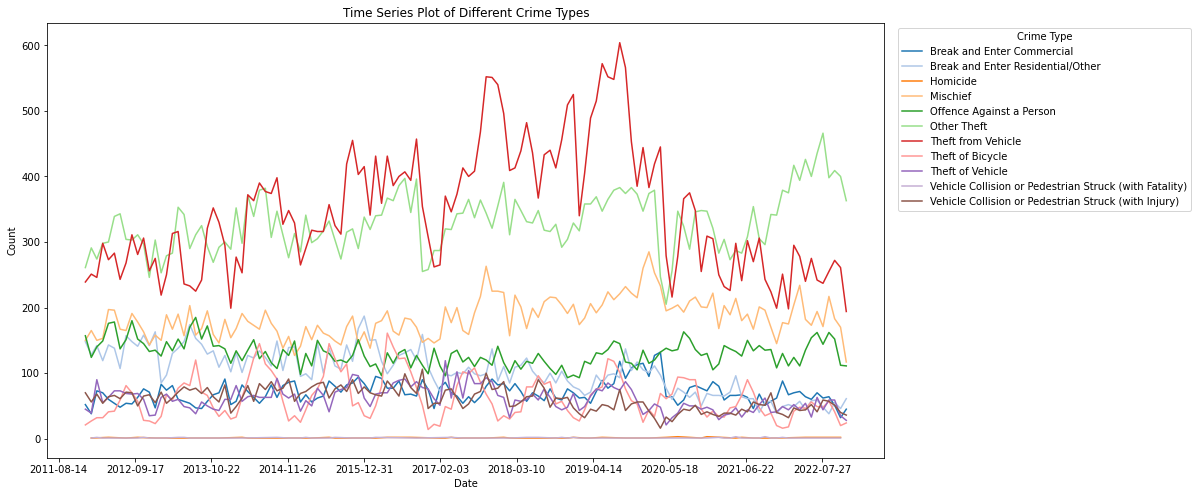

In [17]:
# Reset the index and create a proper 'DATE' column
df_east1 = df_east.reset_index()

# Convert the 'DATE' column to datetime format
df_east1['DATE'] = pd.to_datetime(df_east1['DATE'], format="%Y-%m")

# Create a custom color palette
num_colors = 11  # Adjust this number based on the number of crime types
color_palette = cm.tab20.colors[:num_colors]

# Create a time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_east1, x='DATE', y='COUNT', hue='TYPE', palette=color_palette)

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type')

plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

Plot smoothed time series plot of East area

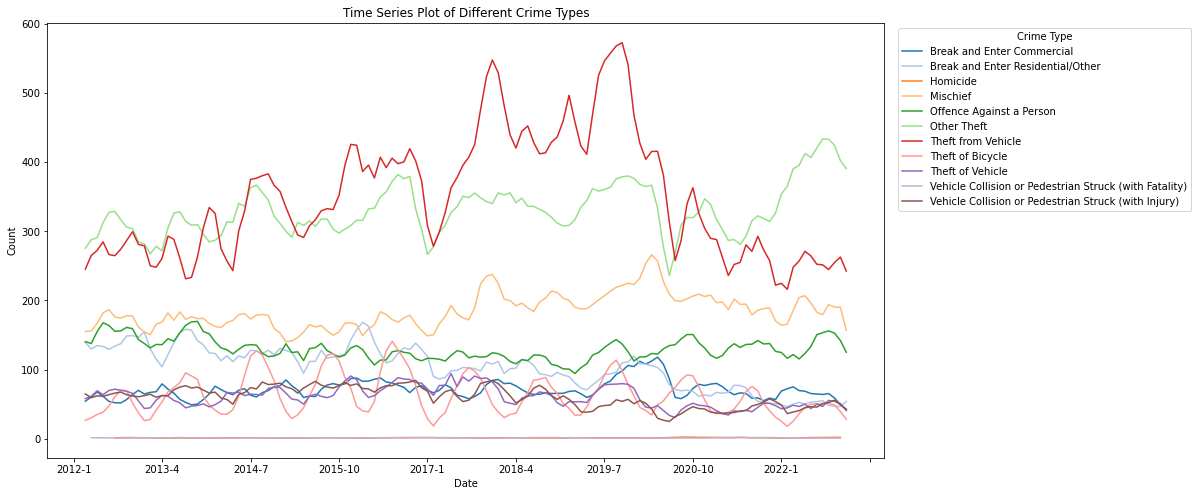

In [18]:
# Using moving average where lag = 3
df_east_smoothed = df_east.groupby(['TYPE']).rolling(window=3).mean()
df_east_smoothed.reset_index(inplace=True)

# Create a smoothed time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_east_smoothed, x='DATE', y='COUNT', hue='TYPE', palette=color_palette, estimator='mean')

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

## Central

In [19]:
# Remove unuseful columns: "YEAR", "MONTH" and "AREA"
df_central = df_central.drop(columns = ['YEAR', 'MONTH', 'AREA'])   
df_central.head()

,TYPE,COUNT
DATE,,
2012-1,Break and Enter Commercial,96
2012-2,Break and Enter Commercial,61
2012-3,Break and Enter Commercial,77
2012-4,Break and Enter Commercial,71
2012-5,Break and Enter Commercial,66


Plot each crime types in central area from 2012 to 2022

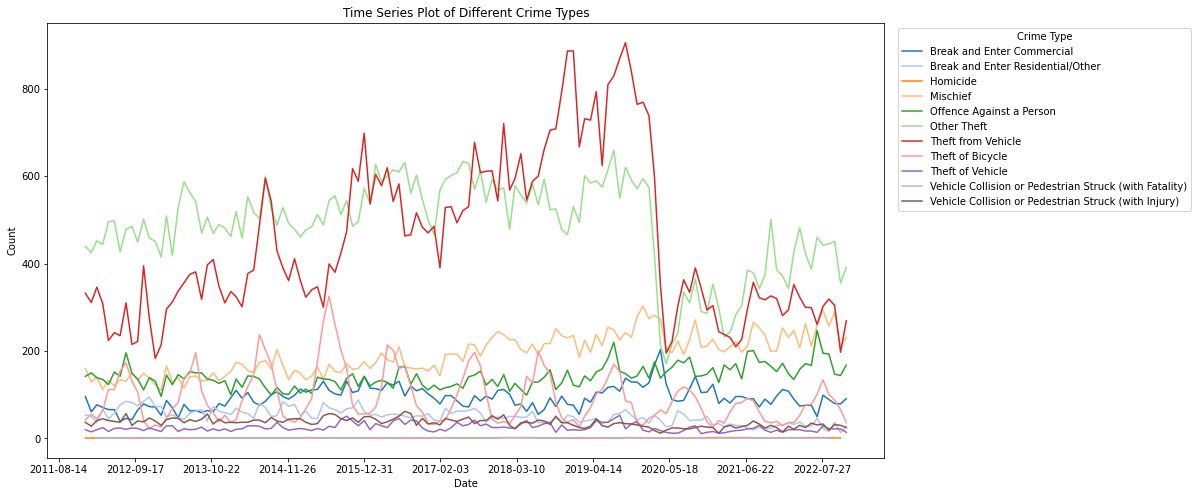

In [20]:
df_central1 = df_central.reset_index()

# Convert the 'DATE' column to datetime format
df_central1['DATE'] = pd.to_datetime(df_central1['DATE'], format="%Y-%m")

# Create a custom color palette
num_colors = 11  # Adjust this number based on the number of crime types
color_palette = cm.tab20.colors[:num_colors]

# Create a time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_central1, x='DATE', y='COUNT', hue='TYPE', palette=color_palette)

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type')

plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

Plot smoothed time series plot of East area

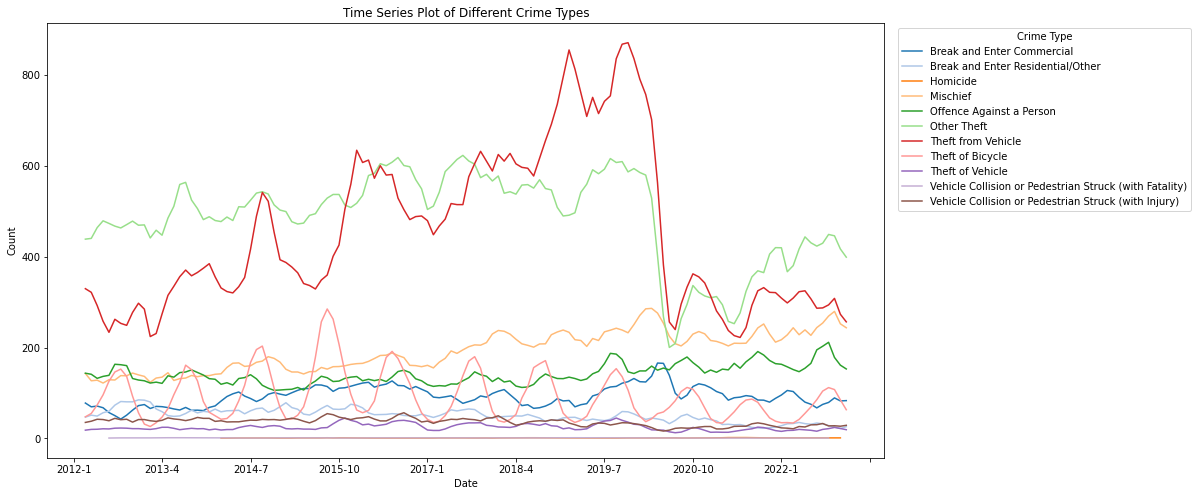

In [21]:
# Using moving average where lag = 3
df_central_smoothed = df_central.groupby(['TYPE']).rolling(window=3).mean()
df_central_smoothed.reset_index(inplace=True)

# Create a smoothed time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_central_smoothed, x='DATE', y='COUNT', hue='TYPE', palette=color_palette, estimator='mean')

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

## Building Models to Forecast Future Number of Crimes

### Building Models of Theft from Vehicle in the West Area

As we can see from above plots, no matter in which areas, theft from vehicle is the main crime in Vancouver, so we will focus on analyzing this type of crime in the this section.

In [22]:
df_west_tv = df_west[df_west['TYPE'] == "Theft from Vehicle"]
df_west_tv.head()

,TYPE,COUNT
DATE,,
2012-1,Theft from Vehicle,94
2012-2,Theft from Vehicle,99
2012-3,Theft from Vehicle,141
2012-4,Theft from Vehicle,152
2012-5,Theft from Vehicle,100


In [23]:
# Get training set and testing set
train = df_west_tv.loc['2012-1':'2021-12'].copy()
test = df_west_tv.loc['2022-1':'2022-12'].copy()

To build a time series model for your data, we should first analyze it to determine which model is appropriate. 
We will separate the data to training set and testing set. The training set is first 10 years data from 2012 to 2021, and the testing set is 1 year data of 2022.

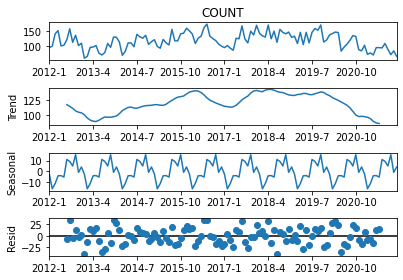

In [24]:
result = seasonal_decompose(train['COUNT'], model='additive', period=12)
fig = result.plot()

# Format x-axis
for ax in fig.axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

In order to build a good model to predict the future number of crimes, we need to make the time series stationary first. The first step is to get rid of the trend and the seasonality. Above plot shows that there is a upward trend and a seasonal effects of period of 12 months.

In [25]:
# Calculate the first difference to make the series stationary
train['COUNT_diff'] = train['COUNT'].diff()
train.dropna(inplace=True)

We take difference to get rid of the trend.

In [26]:
# Perform ADF test to check for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(train['COUNT_diff'])

ADF Statistic: -7.389817
p-value: 0.000000


This Step is to Check for stationarity: We must ensure that the time series is stationary before modeling. A common test for stationarity is the Augmented Dickey-Fuller (ADF) test.
If the p-value is less than the significance level (0.05), the series is stationary.

We can see that the p-value is 0 which is less than 0,05, then it is stationary.

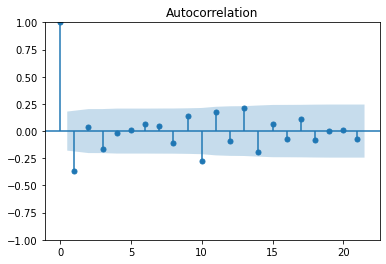

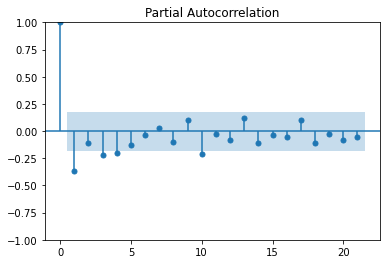

In [27]:
plot_acf(train['COUNT_diff'].dropna())
plot_pacf(train['COUNT_diff'].dropna(), method = 'ywm')
plt.show()

We can see that there is a cut-off at lag 1 in ACF plot, and a cut-off at lag 1 in PACF, so we infer that the model for this time series is ARIMA(1,0,1)(0,0,0)[12]

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Mean Squared Error:  560.754763054286
Mean Absolute Error: 20.015688


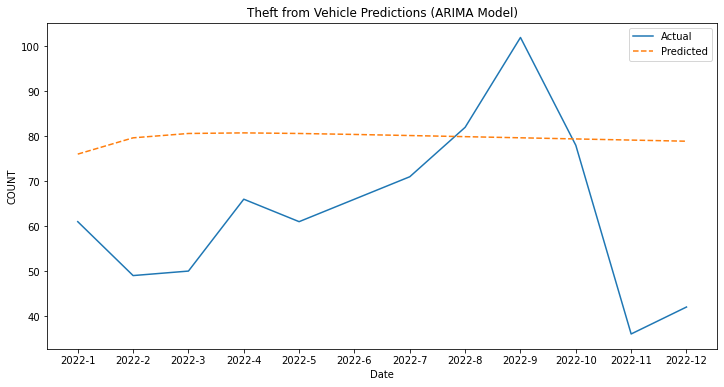

In [28]:
# Fit the ARIMA model
model = ARIMA(train['COUNT_diff'], order=(1,0,1), seasonal_order=(0,0,0,12))
model_fit = model.fit()

forecast_diff = model_fit.forecast(steps=len(test))


# Invert the differencing on the forecasted differences to obtain the actual predicted values
forecast = pd.Series(forecast_diff, index=test.index)
forecast = forecast.cumsum() + train['COUNT'].iloc[-1]

# Calculate MSE and MAE
mse = mean_squared_error(test['COUNT'], forecast)
print("Mean Squared Error: ", mse)

mae = mean_absolute_error(test['COUNT'], forecast)
print('Mean Absolute Error: %f' % mae)

plt.figure(figsize=(12, 6))
plt.plot(test['COUNT'], label='Actual')

# Plot the predicted values
plt.plot(forecast, label='Predicted', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('COUNT')
plt.title('Theft from Vehicle Predictions (ARIMA Model)')
plt.legend()
warnings.filterwarnings("ignore")

The MSE (Mean Squared Error) of ARIMA(1,0,1)(0,0,0)[12] is about 560.8. 
The MAE (Mean Absolute Error) of ARIMA(1,0,1)(0,0,0)[12] is about 20.0. 

In the plot we can see that the predicted values are almost linear, but in fact the actual values are non-linear, so we can try to fit other models to improve the precision of our predictions.

Mean Squared Error: 355.262339
Mean Absolute Error: 15.234608


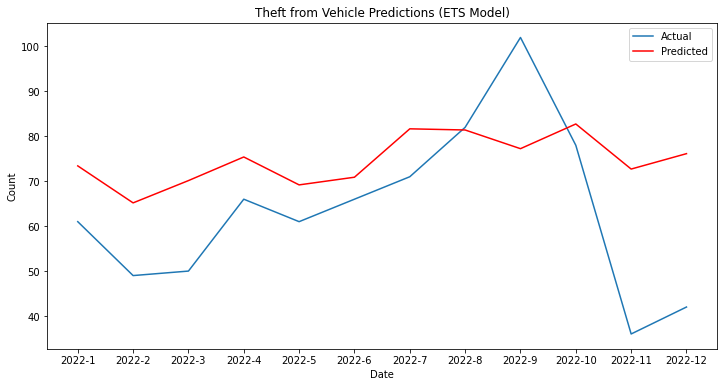

In [29]:
# Fit Exponential Smoothing State Space Model
model = ExponentialSmoothing(train['COUNT'], trend=None, seasonal='multiplicative', seasonal_periods=12)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(test['COUNT'], predictions)
print('Mean Squared Error: %f' % mse)

mae = mean_absolute_error(test['COUNT'], predictions)
print('Mean Absolute Error: %f' % mae)

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['COUNT'], label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Theft from Vehicle Predictions (ETS Model)')
plt.legend()
warnings.filterwarnings("ignore")

The MSE of Exponential Smoothing model is about 355.3 and its MAE is 15.2, which is much better than ARIMA model. Also in the plot, the predicted values are much closer to the actual values. 

Therefore, for theft from vehicle in the west area, we prefer Exponential Smoothing model.

### Building Models of Theft from Vehicle in the East Area

Let's find out which models have better prediction power: ARIMA model or Exponential Smoothing model.

First, we repeat the same steps in the previous analysis.

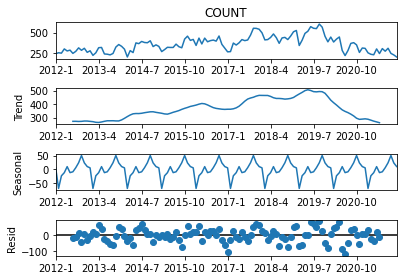

In [30]:
# Get training set and testing set
df_east_tv = df_east[df_east['TYPE'] == "Theft from Vehicle"]
train = df_east_tv.loc['2012-1':'2021-12'].copy()
test = df_east_tv.loc['2022-1':'2022-12'].copy()

# Find trend and seasonality
result = seasonal_decompose(train['COUNT'], model='additive', period=12)
fig = result.plot()
# Format x-axis
for ax in fig.axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

We can see a clear upward trend and seasonality in the training set.

In [31]:
# Get rid of its trend
train['COUNT_diff'] = train['COUNT'].diff()
train.dropna(inplace=True)

# Perform ADF test to check for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(train['COUNT_diff'])

ADF Statistic: -8.621995
p-value: 0.000000


According to the Augmented Dickey-Fuller (ADF) test, we can see that after we differencing the data, our data becomes stationary.

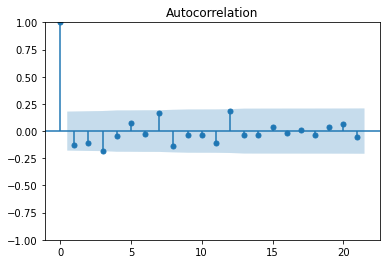

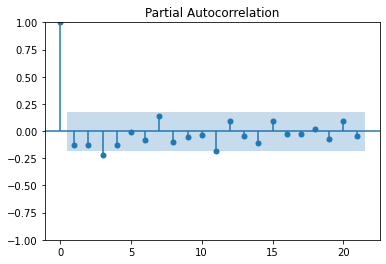

In [32]:
plot_acf(train['COUNT_diff'].dropna())
plot_pacf(train['COUNT_diff'].dropna(), method = 'ywm')
plt.show()

From the plots of ACF and PACF, we can see that both have cut-off at lag 0, so it is hard to determine which ARIMA model to use.

Then I will use auto_arima function to help me determine the parameters of ARIMA model.

In [33]:
best_model= auto_arima(train['COUNT_diff'], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1294.010, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1292.494, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1292.804, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1292.015, Time=0.17 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1291.937, Time=0.32 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1289.772, Time=1.40 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1291.336, Time=3.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1289.574, Time=1.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1292.983, Time=0.68 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1291.424, Time=4.20 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1290.423, Time=1.32 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=1293.310, Time=4.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1289.722, Time=1.51 sec
 ARIMA(0,0,1)(1,0,1)[12]

Mean Squared Error:  2767.6299443233097
Mean Absolute Error: 46.280152


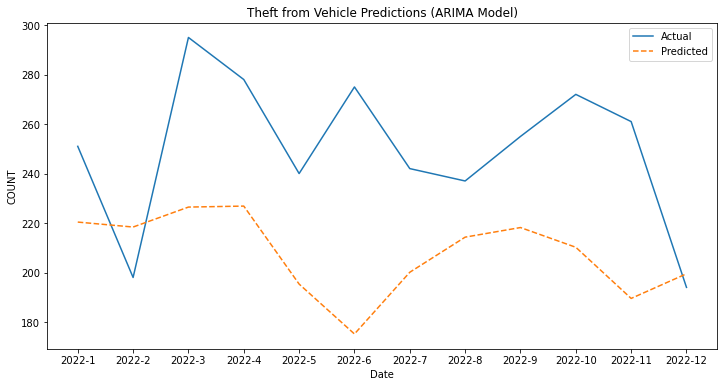

In [34]:
# Fit the best model using the training data
best_model.fit(train['COUNT_diff'])

forecast_diff = best_model.predict(n_periods=len(test))

# Invert the differencing on the forecasted differences to obtain the actual predicted values
forecast = pd.Series(forecast_diff, index=test.index)
forecast = forecast.cumsum() + train['COUNT'].iloc[-1]

# Calculate MSE and MAE
mse = mean_squared_error(test['COUNT'], forecast)
print("Mean Squared Error: ", mse)

mae = mean_absolute_error(test['COUNT'], forecast)
print('Mean Absolute Error: %f' % mae)

plt.figure(figsize=(12, 6))
plt.plot(test['COUNT'], label='Actual')

# Plot the predicted values
plt.plot(forecast, label='Predicted', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('COUNT')
plt.title('Theft from Vehicle Predictions (ARIMA Model)')
plt.legend()
warnings.filterwarnings("ignore")

Mean Squared Error: 3414.779486
Mean Absolute Error: 52.372820


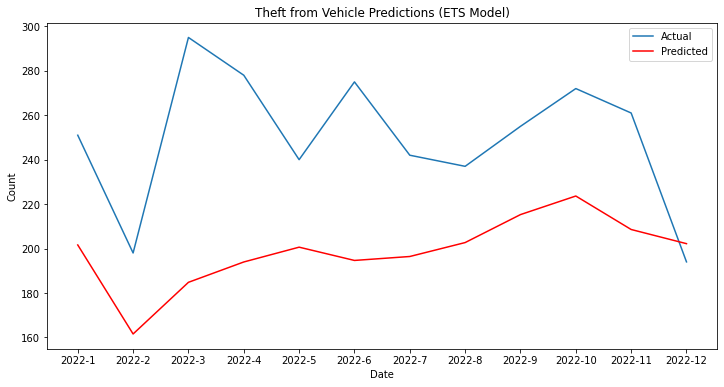

In [35]:
# Fit Exponential Smoothing State Space Model
model = ExponentialSmoothing(train['COUNT'], trend=None, seasonal='mul', seasonal_periods=12)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(test['COUNT'], predictions)
print('Mean Squared Error: %f' % mse)

mae = mean_absolute_error(test['COUNT'], predictions)
print('Mean Absolute Error: %f' % mae)

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['COUNT'], label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Theft from Vehicle Predictions (ETS Model)')
plt.legend()
warnings.filterwarnings("ignore")

The MSE of ARIMA model is about 2767.7 and the MSE of Exponential Smoothing model is 3414.8. 

The MAE of ARIMA model is about 46.3 and the MSE of Exponential Smoothing model is 52.37. 

Therefore, Therefore, for theft from vehicle in the east area, we prefer ARIMA(1,0,1)(0,0,2)[12] because it has lower MSE and lower MAE relatively.

### Building Models of Theft from Vehicle in the Central Area

In this section, we will find out which model can better predict the number of thefts from Vehicle in the central area.

We apply the same procedure as previous again.

,TYPE,COUNT
DATE,,
2012-1,Theft from Vehicle,332
2012-2,Theft from Vehicle,311
2012-3,Theft from Vehicle,346
2012-4,Theft from Vehicle,308
2012-5,Theft from Vehicle,224


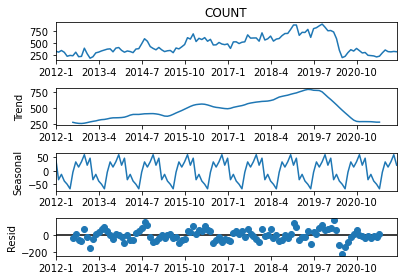

In [36]:
# Get training set and testing set
df_central_tv = df_central[df_central['TYPE'] == "Theft from Vehicle"]
train = df_central_tv.loc['2012-1':'2021-12'].copy()
test = df_central_tv.loc['2022-1':'2022-12'].copy()

# Find trend and seasonality
result = seasonal_decompose(train['COUNT'], model='additive', period=12)
fig = result.plot()
# Format x-axis
for ax in fig.axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
train.head()

We can see a clear upward trend and seasonality in the training set.

In [37]:
# Get rid of its trend
train['COUNT_diff'] = train['COUNT'].diff()
train.dropna(inplace=True)

# Perform ADF test to check for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(train['COUNT_diff'])

ADF Statistic: -12.256491
p-value: 0.000000


By ADF test, we get p-value of 0, then we can know that the detrended data is stationary.

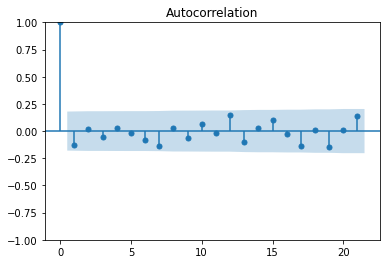

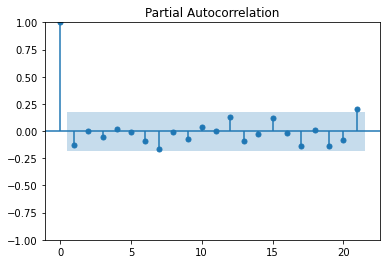

In [38]:
plot_acf(train['COUNT_diff'].dropna())
plot_pacf(train['COUNT_diff'].dropna(), method = 'ywm')
plt.show()

The ACF and PACF  plots are quite same as East area's. Since there is no significant cut-off at any lags in the plots, so we will use auto.arima function again to help us determine the parameters of our ARIMA model. 

In [39]:
best_model= auto_arima(train['COUNT_diff'], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1373.346, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1373.054, Time=0.70 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1373.227, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1371.346, Time=0.10 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1372.653, Time=0.40 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1372.876, Time=0.58 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1370.954, Time=1.60 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1372.953, Time=3.72 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1376.140, Time=2.40 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1374.788, Time=1.40 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1374.106, Time=1.21 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=5.48 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1371.598, Time=2.21 sec
 ARIMA(0,0,1)(1,0,1)[12] inte

Mean Squared Error:  2531.2188905569856
Mean Absolute Error: 39.710388


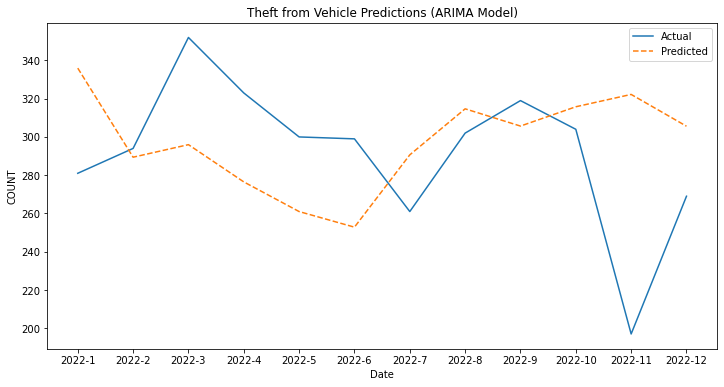

In [40]:
# Fit the best model using the training data
best_model.fit(train['COUNT_diff'])

forecast_diff = best_model.predict(n_periods=len(test))

# Invert the differencing on the forecasted differences to obtain the actual predicted values
forecast = pd.Series(forecast_diff, index=test.index)
forecast = forecast.cumsum() + train['COUNT'].iloc[-1]

# Calculate MSE and MAE
mse = mean_squared_error(test['COUNT'], forecast)
print("Mean Squared Error: ", mse)

mae = mean_absolute_error(test['COUNT'], forecast)
print('Mean Absolute Error: %f' % mae)

# Make plots
plt.figure(figsize=(12, 6))
plt.plot(test['COUNT'], label='Actual')

# Plot the predicted values
plt.plot(forecast, label='Predicted', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('COUNT')
plt.title('Theft from Vehicle Predictions (ARIMA Model)')
plt.legend()

Mean Squared Error: 3334.809445
Mean Absolute Error: 48.155681


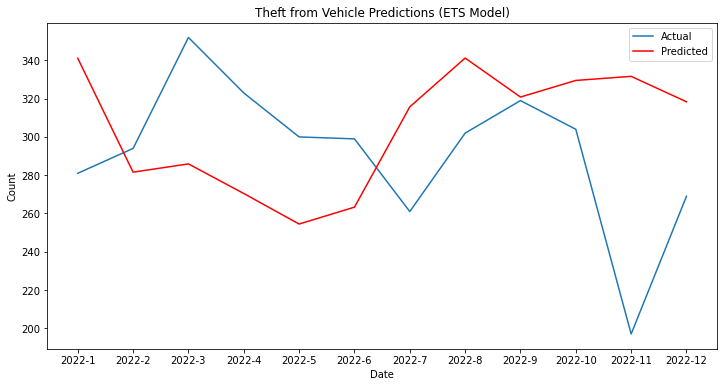

In [41]:
# Fit Exponential Smoothing State Space Model
model = ExponentialSmoothing(train['COUNT'], trend=None, seasonal='mul', seasonal_periods=12)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(test['COUNT'], predictions)
print('Mean Squared Error: %f' % mse)

mae = mean_absolute_error(test['COUNT'], predictions)
print('Mean Absolute Error: %f' % mae)

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['COUNT'], label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Theft from Vehicle Predictions (ETS Model)')
plt.legend()
warnings.filterwarnings("ignore")

The MSE of ARIMA model is about 2531.2 and the MSE of Exponential Smoothing model is 3334.8. 

The MAE of ARIMA model is about 39.7 and the MSE of Exponential Smoothing model is 48.2. 

Therefore, for theft from vehicle in the central area, we prefer ARIMA(0,0,0)(1,0,1)[12] because it has lower MSE and lower MAE relatively.

## Analysis of model building and model selection

In model building section, we built two different models for theft from vehicle in the three areas of Vancouver. Based on MSE and MAE on the test set, we can do model selection. We choose Exponential Smoothing model for the west area, and ARIMA model for the east area and the central area. 

The differences in the best-fitting models for theft from vehicle in the three areas of Vancouver can be attributed to various factors, including the underlying patterns of criminal activity, local characteristics, and other demographic or socioeconomic factors.

One possible explanation for the different models in each area is that the time series patterns of theft from vehicle in each area might exhibit different levels of seasonality, trend, or noise components. While the Exponential Smoothing model captures the seasonal component more explicitly, the ARIMA model is better at handling trends and noise. In areas where seasonality is more dominant, such as the west area, the Exponential Smoothing model may outperform the ARIMA model. On the other hand, in areas where trend and noise components are more critical, like the east and central areas, the ARIMA model might perform better.

Another factor that could contribute to the difference in the best-fitting models is socioeconomic factors. A study by Andresen and Linning (2012) found that crime patterns in Vancouver can be influenced by different socioeconomic factors across neighborhoods, leading to differences in the distribution of crime types. Understanding these factors can help to explain why different models might be preferred for predicting theft from vehicle crimes in different areas of Vancouver.

## 4.  Exploratory Data Analysis:


#### A) Summary View

In [42]:
# Summary table of dataset
df.describe()

,YEAR,MONTH,LATITUDE,LONGITUDE
count,854463.000000,854463.000000,854463.000000,854463.000000
mean,2011.946774,6.511154,44.972886,-123.488779
std,5.986909,3.418603,13.892238,1.236080
min,2003.000000,1.000000,0.000000,-127.488744
25%,2006.000000,4.000000,49.240637,-123.134903
50%,2012.000000,7.000000,49.267125,-123.115949
75%,2017.000000,9.000000,49.281197,-123.090913
max,2023.000000,12.000000,49.313349,-123.022987


viz:
bar chart - count / percentage of crime

map - number of crime in map

pie - type of crime in each area

line graphs - count of crime in different years for each area

pivot table - Which months have the highest and lowest average number crimes?\

heat map  - Trend within the year? - heatmap with months and categories 

### 5. Empirical Analysis

### 6. Conclusion

### 7. Limitation

### 8. Area for Further Reserch

### 9. References

Andresen, M. A., & Linning, S. J. (2012). The (in) appropriateness of aggregating across crime types. Applied Geography, 35(1-2), 275-282.